In [1]:
from PIL import Image
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import cv2
from itertools import compress

from scipy.ndimage import maximum_filter
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import convolve1d as conv1
from scipy.ndimage.filters import convolve as conv2

from skimage.io import imread
from skimage.transform import ProjectiveTransform, SimilarityTransform, AffineTransform
from skimage.measure import ransac

from utils import gaussian2, maxinterp, circle_points

import time


C:\Users\gufra\AppData\Local\Temp\ipykernel_13176\3978841247.py:9: DeprecationWarning: Please use `map_coordinates` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  from scipy.ndimage.interpolation import map_coordinates
C:\Users\gufra\AppData\Local\Temp\ipykernel_13176\3978841247.py:10: DeprecationWarning: Please use `convolve1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import convolve1d as conv1
C:\Users\gufra\AppData\Local\Temp\ipykernel_13176\3978841247.py:11: DeprecationWarning: Please use `convolve` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import convolve as conv2


In [9]:
def harris(im, sigma=1.0, relTh=0.0001, k=0.04):
    im = im.astype(np.float) # Make sure im is float
    
    # Get smoothing and derivative filters
    g, _, _, _, _, _, = gaussian2(sigma)
    _, gx, gy, _, _, _, = gaussian2(np.sqrt(0.5))
    
    
    # Partial derivatives
    Ix = conv2(im, -gx, mode='constant')
    Iy = conv2(im, -gy, mode='constant')


    
    # Components of the second moment matrix
    Ix2Sm = conv2(Ix**2, g, mode='constant')
    Iy2Sm = conv2(Iy**2, g, mode='constant')
    IxIySm = conv2(Ix*Iy, g, mode='constant')
    
    # Determinant and trace for calculating the corner response
    detC = (Ix2Sm*IxIySm)-(Iy2Sm**2)
    traceC = Ix2Sm+IxIySm
    
    # Corner response function R
    # "Corner": R > 0
    # "Edge": R < 0
    # "Flat": |R| = small
    R = detC-k*traceC**2
    maxCornerValue = np.amax(R)
    
    # Take only the local maxima of the corner response function
    fp = np.ones((3,3))
    fp[1,1] = 0
    maxImg = maximum_filter(R, footprint=fp, mode='constant')
    
    # Test if cornerness is larger than neighborhood
    cornerImg = R>maxImg
    
    # Threshold for low value maxima
    y, x = np.nonzero((R>relTh*maxCornerValue)*cornerImg) 
    
    # Convert to float
    x = x.astype(np.float)
    y = y.astype(np.float)
    
    # Remove responses from image borders to reduce false corner detections
    r, c = R.shape
    idx = np.nonzero((x<2)+(x>c-3)+(y<2)+(y>r-3))[0]
    x = np.delete(x,idx)
    y = np.delete(y,idx)
    
    # Parabolic interpolation
    for i in range(len(x)):
        _,dx=maxinterp((R[int(y[i]), int(x[i])-1], R[int(y[i]), int(x[i])], R[int(y[i]), int(x[i])+1]))
        _,dy=maxinterp((R[int(y[i])-1, int(x[i])], R[int(y[i]), int(x[i])], R[int(y[i])+1, int(x[i])]))
        x[i]=x[i]+dx
        y[i]=y[i]+dy
        
    return x, y, cornerImg

C:\Users\gufra\AppData\Local\Temp\ipykernel_13176\2012576770.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  im = im.astype(np.float) # Make sure im is float
C:\Users\gufra\AppData\Local\Temp\ipykernel_13176\2012576770.py:43: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x = x.astype(np.float)
C:\Users\gufra\AppData\Local\Temp\ipykern

214 correct matches.


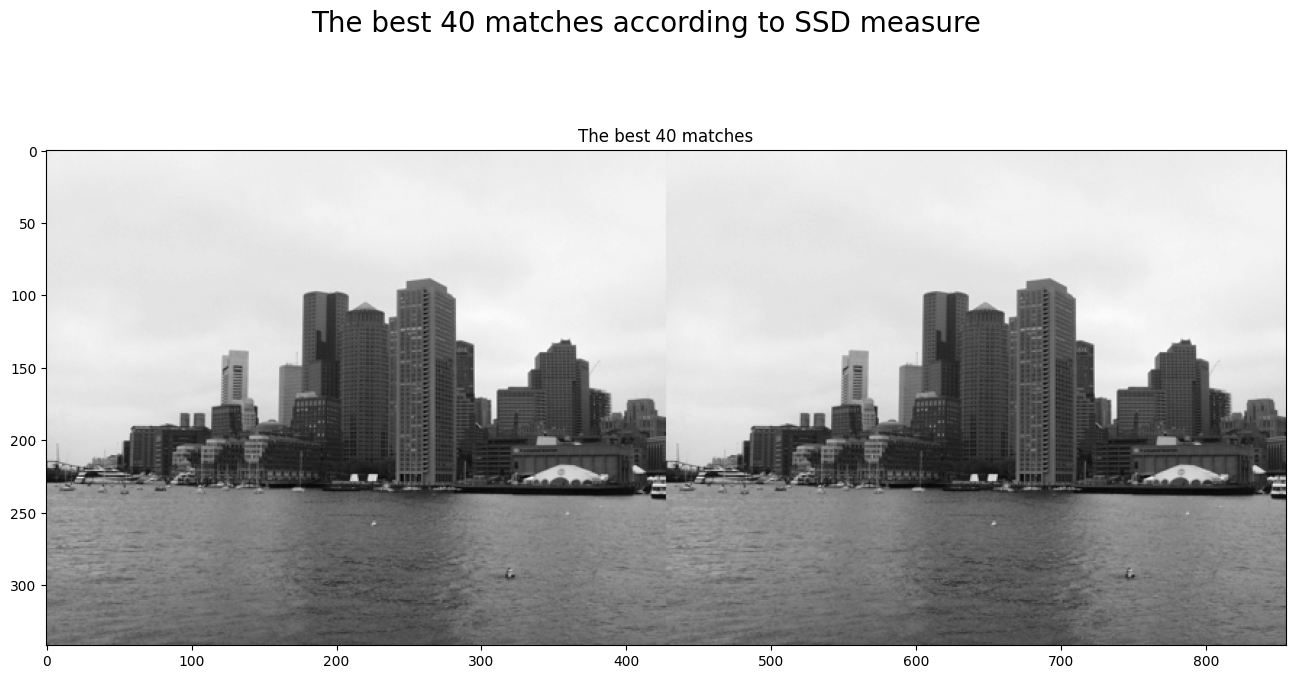

In [11]:
# Load images
I1 = imread('Boston1.png')/255.
I2 = imread('Boston1.png')/255.

# Harris corner extraction, take a look at the source code above
x1, y1, cimg1 = harris(I1)
x2, y2, cimg2 = harris(I2)

## We pre-allocate the memory for the 15*15 image patches extracted
## around each corner point from both images
patch_size=15
npts1=x1.shape[0]
npts2=x2.shape[0]
patches1=np.zeros((patch_size, patch_size, npts1))
patches2=np.zeros((patch_size, patch_size, npts2))

## The following part extracts the patches using bilinear interpolation
k=(patch_size-1)/2.
xv,yv=np.meshgrid(np.arange(-k,k+1),np.arange(-k, k+1))
for i in range(npts1):
    patch = map_coordinates(I1, (yv + y1[i], xv + x1[i]))
    patches1[:,:,i] = patch
for i in range(npts2):
    patch = map_coordinates(I2, (yv + y2[i], xv + x2[i]))
    patches2[:,:,i] = patch

## We compute the sum of squared differences (SSD) of pixels' intensities
## for all pairs of patches extracted from the two images
distmat = np.zeros((npts1, npts2))
for i1 in range(npts1):
    for i2 in range(npts2):
        distmat[i1,i2]=np.sum((patches1[:,:,i1]-patches2[:,:,i2])**2)

## Next we compute pairs of patches that are mutually nearest neighbors
## according to the SSD measure
ss1 = np.amin(distmat, axis=1)
ids1 = np.argmin(distmat, axis=1)
ss2 = np.amin(distmat, axis=0)
ids2 = np.argmin(distmat, axis=0)

pairs = []
for k in range(npts1):
    if k == ids2[ids1[k]]:
        pairs.append(np.array([k, ids1[k], ss1[k]]))
pairs = np.array(pairs)

## We sort the mutually nearest neighbors based on the SSD
sorted_ssd = np.sort(pairs[:,2], axis=0)
id_ssd = np.argsort(pairs[:,2], axis=0)

## Estimate the geometric transformation between images
src=[]
dst=[]
for k in range(len(id_ssd)):
    l = id_ssd[k]
    src.append([x1[int(pairs[l, 0])], y1[int(pairs[l, 0])]])
    dst.append([x2[int(pairs[l, 1])], y2[int(pairs[l, 1])]])
src=np.array(src)
dst=np.array(dst)
rthrs=2
tform,_ = ransac((src, dst), ProjectiveTransform, min_samples=4,
                               residual_threshold=rthrs, max_trials=1000)
H1to2p = tform.params

## Next we visualize the 40 best matches which are mutual nearest neighbors
## and have the smallest SSD values
Nvis = 40
montage = np.concatenate((I1, I2), axis=1)

plt.figure(figsize=(16, 8))
plt.suptitle("The best 40 matches according to SSD measure", fontsize=20)
plt.imshow(montage, cmap='gray')
plt.title('The best 40 matches')
for k in range(np.minimum(len(id_ssd), Nvis)):
    l = id_ssd[k]
    plt.plot(x1[int(pairs[l, 0])], y1[int(pairs[l, 0])], 'rx')
    plt.plot(x2[int(pairs[l, 1])] + I1.shape[1], y2[int(pairs[l, 1])], 'rx')
    plt.plot([x1[int(pairs[l, 0])], x2[int(pairs[l, 1])]+I1.shape[1]], 
         [y1[int(pairs[l, 0])], y2[int(pairs[l, 1])]])

## Finally, since we have estimated the planar projective transformation
## we can check that how many of the nearest neighbor matches actually
## are correct correspondences
p1to2=np.dot(H1to2p, np.hstack((src, np.ones((src.shape[0],1)))).T)
p1to2 = p1to2[:2,:] / p1to2[2,:]
p1to2 = p1to2.T
pdiff=np.sqrt(np.sum((dst-p1to2)**2, axis=1))

# The criterion for the match being a correct is that its correspondence in
# the second image should be at most rthrs=2 pixels away from the transformed
# location
n_correct = len(pdiff[pdiff<rthrs])
print("{} correct matches.".format(n_correct))